# California Housing
This dataset appeared in a 1997 paper titled Sparse Spatial Autoregressions by Pace, R. Kelley and Ronald Barry, published in the Statistics and Probability Letters journal. They built it using the 1990 California census data. It contains one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people).

Variables:

|                |                                                                                                   |
|----------------|---------------------------------------------------------------------------------------------------|
|longitude       |A measure of how far west a house is;<br>a higher value is farther west                               |
|latitude        |A measure of how far north a house is;<br>a higher value is farther north                             |
|housingMedianAge|Median age of a house within a block;<br>a lower number is a newer building                           |
|totalRooms      |Total number of rooms within a block                                                               |
|totalBedrooms   |Total number of bedrooms within a block                                                            |
|population      |Total number of people residing within a block                                                     |
|households      |Total number of households, a group of people<br>residing within a home unit, for a block             |
|medianIncome    |Median income for households within a block of houses<br>(measured in tens of thousands of US Dollars)|
|medianHouseValue|Median house value for households within a block<br>(measured in US Dollars)                          |

In [1]:
import pandas as pd
from matplotlib import transforms, pyplot as plt
import numpy as np

%matplotlib inline

# define plots common properties and color constants
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['axes.linewidth'] = 0.5
GRAY1, GRAY4, GRAY7 = '#231F20', '#646369', '#929497'

## Load and Prepare Data

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
df = pd.read_csv("../data/California Housing.txt")
df.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [4]:
# rename columns to be consistent with the book
df.rename(columns={
    'population': 'Population',
    'housingMedianAge': 'HouseAge',
    'longitude': 'Longitude',
    'latitude': 'Latitude',
    'medianIncome': 'MedInc',
    'medianHouseValue': 'MedHouseVal'}, inplace=True)
df['MedHouseVal'] /= 100000

# calculate average values from total values
df['AveBedrms'] = df['totalBedrooms'] / df['households']
df['AveRooms'] = df['totalRooms'] / df['households']
df['AveOccup'] = df['Population'] / df['households']

# PAGE 371. The response variable Y is the median house value in each
#           neighborhood measured in units of $100,000.
target = 'MedHouseVal'

# PAGE 371. The predictor variables are demographics such as median income
#           MedInc, housing density as reflected by the number of houses House,
#           and the average occupancy in each house AveOccup. Also included as
#           predictors are the location of each neighborhood (longitude and
#           latitude), and several quantities reflecting the properties of the
#           houses in the neighborhood: average number of rooms AveRooms and
#           bedrooms AveBedrms. There are thus a total of eight predictors,
#           all numeric.
features = ['Population', 'AveBedrms', 'AveRooms', 'HouseAge',
            'Latitude', 'AveOccup', 'Longitude', 'MedInc']

X, y = df[features].values, df[target].values

# PAGE 371. We randomly divided the dataset into a training set (80%)
#           and a test set (20%).
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=2311)
y_overall_median = np.median(y)

## Baseline

In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [6]:
y_train_median = np.median(y_train)
y_test_hat = np.full(shape=y_test.shape, fill_value=y_train_median)
const_mae = mean_absolute_error(y_test, y_test_hat)
print(f'MAE of optimal constant predictor {const_mae:.2f}')

MAE of optimal constant predictor 0.88


## Boosting
There are some differences with the book. The Huber loss is used there, and we use MAE. The number of terminal nodes is J=6, but is not limited in our solution. Also in the book 800 iterations are made, we do 1500.

In [7]:
from catboost import CatBoostRegressor

In [8]:
# PAGE 371. We fit a gradient boosting model using the MART procedure, with J=6
#           terminal nodes, a learning rate (10.41) of ν = 0.1, and the Huber
#           loss criterion for predicting the numeric response.
cb_reg = CatBoostRegressor(
    iterations=1500,
    loss_function='MAE'
).fit(
    X_train, y_train,
    verbose=False,
    # include train into eval_set to calculate error curve for it
    # don't to it when selecting the best model
    eval_set=[(X_train, y_train), (X_test, y_test)]
)

In [9]:
# PAGE 371. The value of AAE after 800 iterations is 0.31. This can be compared
#           to that of the optimal constant predictor median{yi} which is 0.89.
#           In terms of more familiar quantities, the squared multiple
#           correlation coefficient of this model is R2 = 0.84.
y_test_hat = cb_reg.predict(X_test)
cb_mae = mean_absolute_error(y_test, y_test_hat)
cb_r2 = r2_score(y_test, y_test_hat)
print(f'CatBoost MAE={cb_mae:.2f}, R^2={cb_r2:.2f}')

CatBoost MAE=0.30, R^2=0.82


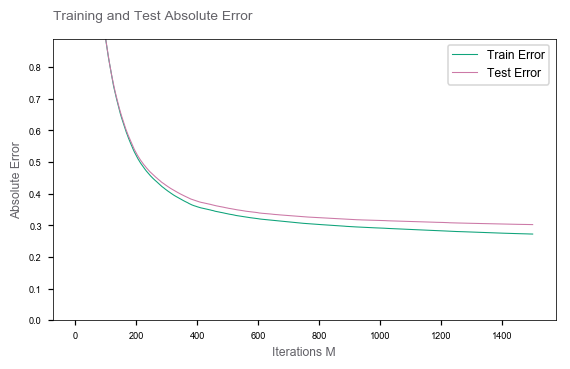

In [10]:
# PAGE 371. Figure 10.13 shows the average absolute error (10.53)
#           as a function for number of iterations M on both the training data
#           and test data. The test error is seen to decrease monotonically
#           with increasing M, more rapidly during the early stages and then
#           leveling off to being nearly constant as iterations increase. Thus,
#           the choice of a particular value of M is not critical, as long as
#           it is not too small.

# PAGE 372. FIGURE 10.13. Average-absolute error as a function of number of
#           iterations for the California housing data.
train_error = cb_reg.get_evals_result()['validation_0']['MAE']
test_error = cb_reg.get_evals_result()['validation_1']['MAE']
fig, ax = plt.subplots(figsize=(5.9, 3.39), dpi=110)
ax.set_xlabel('Iterations M', color=GRAY4, fontsize=8)
ax.set_ylabel('Absolute Error', color=GRAY4, fontsize=8)
ax.plot(range(len(train_error)), train_error,
        label='Train Error', color='#10A47B', linewidth=0.7)
ax.plot(range(len(test_error)), test_error,
        label='Test Error', color='#CC79A7', linewidth=0.7)
ax.set_ylim(0, 0.89)
for i in ax.get_yticklabels() + ax.get_xticklabels():
    i.set_fontsize(6)
ax.text(ax.get_xlim()[0], 0.95, 'Training and Test Absolute Error',
        color=GRAY4, fontsize=9)
_ = ax.legend(loc='upper right', prop={'size': 8})

## Relative Importance of the Predictors

In [11]:
# PAGE 372. Figure 10.14 displays the relative variable importances for each of
#           the eight predictor variables. Not surprisingly, median income in
#           the neighborhood is the most relevant predictor.
importance = np.array(cb_reg.get_feature_importance())
max_importance = np.max(importance)
relative_importance = sorted(zip(100*importance/max_importance, features))

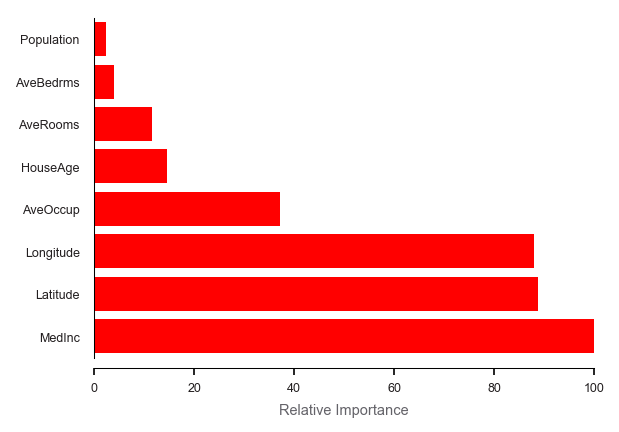

In [12]:
# PAGE 373. FIGURE 10.14. Relative importance of the predictors for the
#           California housing data.
yticks = np.arange(len(relative_importance))
yticklabels = [ri[1] for ri in relative_importance][::-1]
bars_sizes = [ri[0] for ri in relative_importance][::-1]

fig, ax = plt.subplots(figsize=(4.3, 3), dpi=150)
bars = ax.barh(yticks, bars_sizes, height=0.8, color='red')
plt.setp(ax, yticks=yticks, yticklabels=yticklabels)
ax.set_xlim([0, 100])
ax.set_ylim([-0.5, 7.5])
for e in ax.get_yticklabels()+ax.get_xticklabels():
    e.set_fontsize(6)
    e.set_color(GRAY1)
ax.tick_params(left=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
offset = transforms.ScaledTranslation(0, -0.07, fig.dpi_scale_trans)
for e in ax.get_xticklabels() + ax.xaxis.get_ticklines() + \
         [ax.spines['bottom']]:
    e.set_transform(e.get_transform() + offset)
ax.spines['bottom'].set_bounds(0, 100)
_ = ax.set_xlabel('Relative Importance', color=GRAY4, fontsize=7)

## Partial Dependance

In [13]:
# PAGE 372. Figure 10.15 shows single-variable partial dependence plots on the
#           most relevant nonlocation predictors. Note that the plots are not
#           strictly smooth. This is a consequence of using tree-based models.
def plot_partial_dependence(ax, feature, y_lim):
    n = features.index(feature)
    X_tmp = X.copy()
    vals = np.unique(np.percentile(X_tmp[:, n], np.linspace(1, 99, 100)))
    result = []
    for i in range(vals.shape[0]):
        X_tmp[:, n] = vals[i]
        result.append(np.mean(cb_reg.predict(X_tmp), axis=0)-y_overall_median)
    ax.plot(vals, result, linewidth=0.6, color='#26FF26')
    for e in ax.get_yticklabels() + ax.get_xticklabels():
        e.set_fontsize(4)
    ax.set_ylabel('Partial Dependance', color=GRAY4, fontsize=6)
    ax.set_xlabel(f'{feature}', color=GRAY4, fontsize=6)
    ax.yaxis.set_label_coords(-0.15, 0.5)
    ax.xaxis.set_label_coords(0.5, -0.15)

    # plot small red lines for the data deciles
    deciles = np.percentile(X[:, n], np.linspace(10, 90, 9))
    y_from, y_to = y_lim
    for i in range(deciles.shape[0]):
        x = deciles[i]
        ax.plot([x, x], [y_from, y_from+(y_to-y_from)*0.05],
                color='red', linewidth=0.4)
    ax.set_ylim(y_lim)

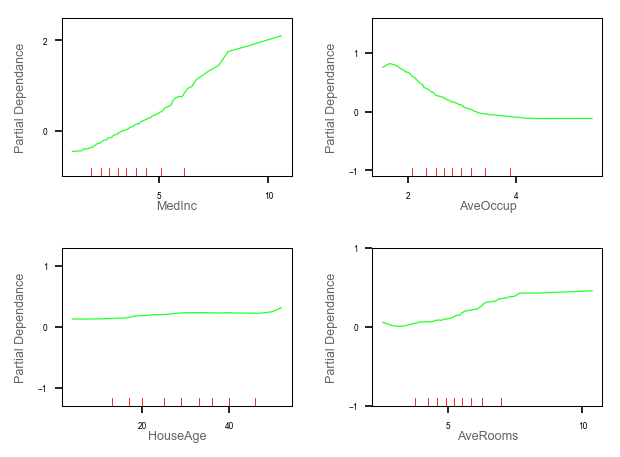

In [14]:
# PAGE 374. FIGURE 10.15. Partial dependence of housing value on the
#           nonlocation variables for the California housing data. The red
#           ticks at the base of the plot are deciles of the input variables.
fig, axarr = plt.subplots(2, 2, figsize=(4.65, 3.43), dpi=150)
plt.subplots_adjust(wspace=0.35, hspace=0.45)
plot_partial_dependence(axarr[0, 0], 'MedInc', (-1, 2.5))
plot_partial_dependence(axarr[0, 1], 'AveOccup', (-1.1, 1.6))
plot_partial_dependence(axarr[1, 0], 'HouseAge', (-1.3, 1.3))
plot_partial_dependence(axarr[1, 1], 'AveRooms', (-1, 1))

## Mutual Partial Dependance

In [15]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

# prepare colormap the looks similar to colormap from the book
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(1, 0, N)
vals[:, 1] = np.linspace(0, 1, N)
vals[:, 2] = np.linspace(1, 1, N)
newcmp = ListedColormap(vals)

In [16]:
# PAGE 373. Median house value is seen to have a very weak partial dependence
#           on house age that is inconsistent with its importance ranking
#           (Figure 10.14). This suggests that this weak main effect may be
#           masking stronger interaction effects with other variables.

# calculate coordinates grids for surface and frame plotting
n1, n2 = features.index('AveOccup'), features.index('HouseAge')
vals1, vals2 = np.linspace(1.5, 5.5, 30), np.linspace(5, 50, 30)
N1, N2 = np.meshgrid(vals1, vals2)
Y = np.zeros(shape=N1.shape)

X_tmp = X.copy()
for i in range(N1.shape[0]):
    for j in range(N1.shape[1]):
        X_tmp[:, n1], X_tmp[:, n2] = N1[i, j], N2[i, j]
        Y[i, j] = np.mean(cb_reg.predict(X_tmp), axis=0) - y_overall_median

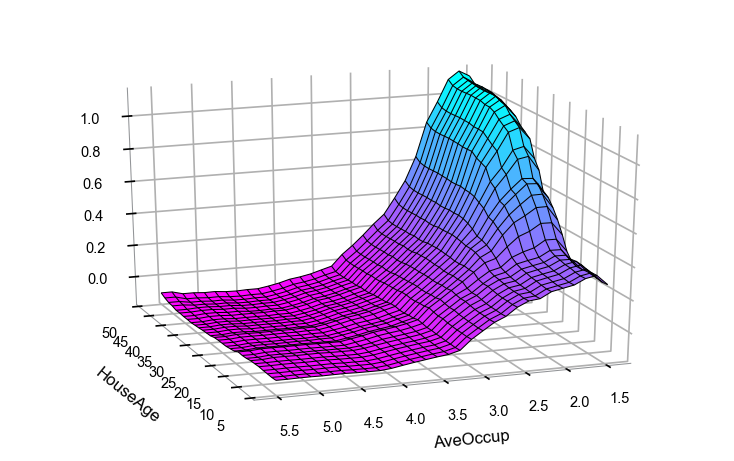

In [17]:
# PAGE 374. FIGURE 10.16. Partial dependence of house value on median age and
#           average occupancy. There appears to be a strong interaction effect
#           between these two variables.
fig = plt.figure(figsize=(6, 3.75), dpi=150)
ax = fig.add_subplot(111, projection='3d')
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.set_xlabel('AveOccup', fontsize=8)
ax.set_ylabel('HouseAge', fontsize=8)
ax.w_xaxis.line.set_color(GRAY7)
ax.w_yaxis.line.set_color(GRAY7)
ax.w_zaxis.line.set_color(GRAY7)
ax.view_init(22, 70)
# invert y-axis
ax.set_ylim(50, 5)
for e in ax.get_yticklabels() + ax.get_xticklabels() + \
         ax.get_zticklabels():
    e.set_fontsize(7)

ax.plot_surface(N1, N2, Y, cmap=newcmp, shade=False)
_ = ax.plot_wireframe(N1, N2, Y, cmap=newcmp, linewidth=0.5, color='black')

In [22]:
lon_idx, lat_idx = features.index('Longitude'), features.index('Latitude')
lon, lat = X[:, lon_idx], X[:, lat_idx]
pd_vals = np.zeros(shape=lon.shape)
X_tmp = X[np.random.choice(X.shape[0], 300, replace=False), :]
for i in range(0, lon.shape[0]):
    X_tmp[:, lon_idx], X_tmp[:, lat_idx] = lon[i], lat[i]
    pd_vals[i] = np.mean(cb_reg.predict(X_tmp), axis=0) - y_overall_median

In [28]:
color_list = np.array([
    [247, 252, 253, 256],
    [224, 236, 244, 256],
    [191, 211, 230, 256],
    [158, 188, 218, 256],
    [140, 150, 198, 256],
    [140, 107, 177, 256],
    [136, 65,  157, 256],
    [129, 15,  124, 256],
    [77,  0,   75,  256]
])/256
newcmp2 = ListedColormap(color_list)

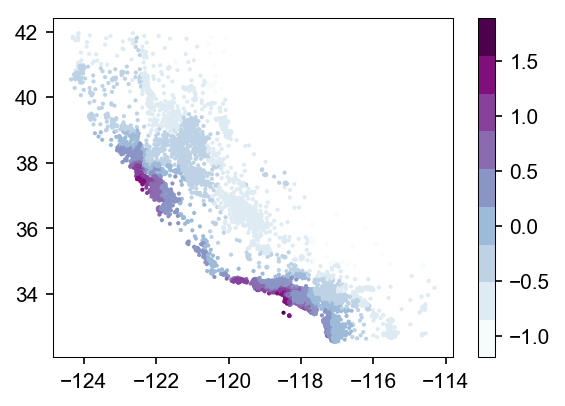

In [46]:
fig, ax = plt.subplots(figsize=(4.3, 3), dpi=150)
plt.scatter(lon, lat, c=pd_vals, s=1, cmap=newcmp2)
plt.colorbar()